In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
from vae import VariationalAutoEncoder
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import os
from utils import scheduler, plot_manifold, plot_history, plot_rescontruction_and_actual_images, mse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Load and preprocess data

In [13]:
exclude_class_0 = True

(x_train, train_labels), (x_test, test_labels) = mnist.load_data()

if exclude_class_0:
    x_train = x_train[train_labels != 0]
    train_labels = train_labels[train_labels != 0]

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

permutation = np.random.permutation(len(x_train))
x_train, train_labels = x_train[permutation], train_labels[permutation]
permutation = np.random.permutation(len(x_test))
x_test, test_labels = x_test[permutation], test_labels[permutation]

x_train = x_train.reshape(len(x_train), 28, 28, 1)
x_test = x_test.reshape(len(x_test), 28, 28, 1)

### 2. Create and train model

In [14]:
cfg = {
    'latent_dim': 2
}
autoencoder = VariationalAutoEncoder(cfg)
autoencoder.compile(optimizer='adam', loss=None)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint('best_model.hdf5', monitor='val_loss', save_best_only=True)
]



history = autoencoder.fit(x=x_train,
                          epochs=30,
                          batch_size=512,
                          shuffle=True,
                          validation_data=(x_test, None),
                          callbacks=callbacks)

Epoch 1/30


2024-06-03 08:43:41.165010: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 169585472 exceeds 10% of free system memory.
2024-06-03 08:43:41.590572: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2024-06-03 08:43:41.642033: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2024-06-03 08:43:41.689333: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.


  1/106 [..............................] - ETA: 1:07 - loss: 0.6940 - reconstruction_loss: 0.6940 - kl_loss: 9.2946e-08

2024-06-03 08:43:41.796584: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.


106/106 [==============================] - 23s 211ms/step - loss: 0.3493 - reconstruction_loss: 0.3412 - kl_loss: 0.0082 - val_loss: 0.2662 - val_reconstruction_loss: 0.2629 - val_kl_loss: 0.0033
Epoch 2/30
106/106 [==============================] - 22s 206ms/step - loss: 0.2501 - reconstruction_loss: 0.2465 - kl_loss: 0.0036 - val_loss: 0.2511 - val_reconstruction_loss: 0.2479 - val_kl_loss: 0.0032
Epoch 3/30
106/106 [==============================] - 22s 207ms/step - loss: 0.2281 - reconstruction_loss: 0.2239 - kl_loss: 0.0042 - val_loss: 0.2273 - val_reconstruction_loss: 0.2240 - val_kl_loss: 0.0032
Epoch 4/30
106/106 [==============================] - 23s 214ms/step - loss: 0.2150 - reconstruction_loss: 0.2118 - kl_loss: 0.0032 - val_loss: 0.2230 - val_reconstruction_loss: 0.2200 - val_kl_loss: 0.0030
Epoch 5/30
106/106 [==============================] - 22s 210ms/step - loss: 0.2101 - reconstruction_loss: 0.2070 - kl_loss: 0.0031 - val_loss: 0.2186 - val_reconstruction_loss: 0.215

KeyboardInterrupt: 

# Research questions

1. Graph the area of the manifold.

2. Calculate the average of the difference between the input and the output

3. Determine the difference between the trained data and the untrained data

4. See what happens when you give the untrained data (0) as input.

### Analysis 1: Graph the area of the manifold
If using latent dimension > 2, please uncomment #latent_transform = TSNE(n_components=2).fit_transform(x_latent) in utils.py and replace 'x_latent' by 'latent_transform'

313/313 [==============================] - 1s 3ms/step


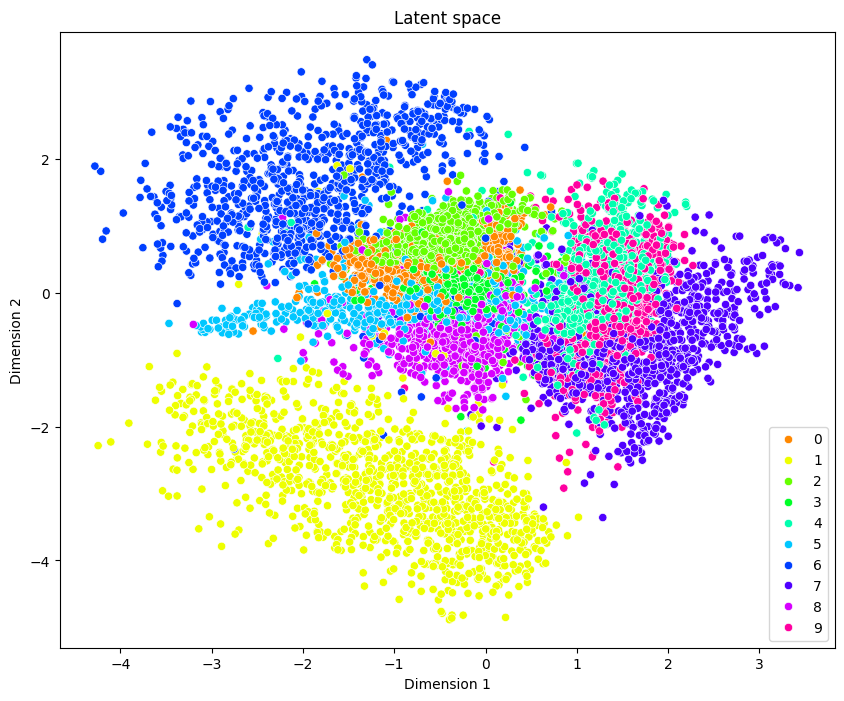

In [15]:
plot_manifold(autoencoder, x_test, test_labels)

### Analysis 2: Calculate the average of the difference between the input and the output

In [16]:
mse_classes = dict()
reconstructed_images = autoencoder.predict(x=x_test)
for r_img, x_t, label in zip(reconstructed_images, x_test, test_labels):
    if label not in mse_classes:
        mse_classes[label] = [mse(r_img, x_t)]
    else:
        mse_classes[label].append(mse(r_img, x_t))
        
avg_mse_classes = dict()
for key, values in mse_classes.items():
    avg_mse_classes[key] = np.mean(values)

avg_mse_classes = dict(sorted(avg_mse_classes.items(), key= lambda x: x[0]))

313/313 [==============================] - 1s 2ms/step


In [17]:
for key, value in avg_mse_classes.items():
    print('Averge mse of class {}: {}'.format(key, value))

Averge mse of class 0: 2.3927339064283664
Averge mse of class 1: 0.30700528828599183
Averge mse of class 2: 1.5140948740659619
Averge mse of class 3: 1.313752779206702
Averge mse of class 4: 1.1630589028342113
Averge mse of class 5: 1.360522131482941
Averge mse of class 6: 1.0577869203872663
Averge mse of class 7: 0.9273793560183763
Averge mse of class 8: 1.3908693798563116
Averge mse of class 9: 0.9615553101717939


### Analysis 3: Determine the difference between the trained data and the untrained data

====> The average MSE of class 0 is larger than all other classes

### Analysis 4: Reconstruction vs Actual images from test data

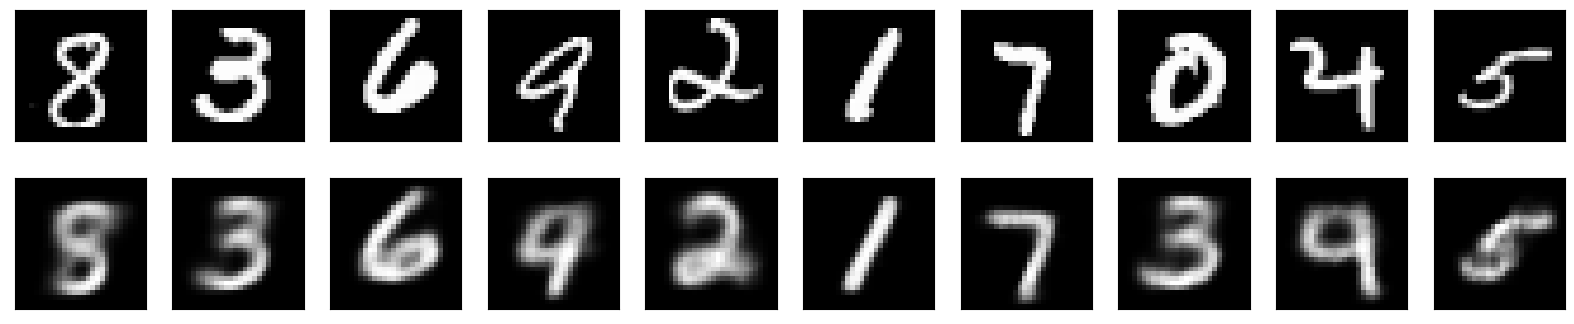

In [7]:
plot_rescontruction_and_actual_images(autoencoder, x_test, test_labels)